In [671]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error,accuracy_score, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [672]:
df = pd.read_csv("../data/DSNY_Monthly_Tonnage_Data.csv")
# changing month to datetime for pandas
df['MONTH'] = pd.to_datetime(df['MONTH'])
df.info()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24647 entries, 0 to 24646
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MONTH                24647 non-null  datetime64[ns]
 1   BOROUGH              24647 non-null  object        
 2   COMMUNITYDISTRICT    24647 non-null  int64         
 3   REFUSETONSCOLLECTED  24647 non-null  float64       
 4   PAPERTONSCOLLECTED   22213 non-null  float64       
 5   MGPTONSCOLLECTED     22570 non-null  float64       
 6   RESORGANICSTONS      3095 non-null   float64       
 7   SCHOOLORGANICTONS    2308 non-null   float64       
 8   LEAVESORGANICTONS    881 non-null    object        
 9   XMASTREETONS         1685 non-null   float64       
 10  OTHERORGANICSTONS    1933 non-null   float64       
 11  BOROUGH_ID           24647 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 2.3+ MB


/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_57940/2461424894.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['MONTH'] = pd.to_datetime(df['MONTH'])


,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,OTHERORGANICSTONS,BOROUGH_ID
0,2025-10-01,Bronx,1,3352.0,235.0,124.8,16.7,85.9,NaN,NaN,NaN,2
1,2025-10-01,Bronx,2,7942.4,231.6,213.8,20.4,100.7,NaN,NaN,NaN,2
2,2025-10-01,Bronx,3,2348.6,140.1,147.5,19.1,NaN,NaN,NaN,NaN,2
3,2025-10-01,Bronx,4,4210.4,233.3,291.1,20.8,70.7,NaN,NaN,0.3,2
4,2025-10-01,Bronx,5,3578.3,216.6,299.9,17.1,85.6,NaN,NaN,NaN,2


In [673]:
df.groupby('BOROUGH')['COMMUNITYDISTRICT'].unique()
# staten island has only 3 community districts (the least)
# manhattan and bronx have 12
# queens and brooklyn have 14+



BOROUGH
Bronx                      [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Brooklyn         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Manhattan                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Queens             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Staten Island                                            [1, 2, 3]
Name: COMMUNITYDISTRICT, dtype: object

<Axes: xlabel='PAPERTONSCOLLECTED', ylabel='REFUSETONSCOLLECTED'>

<Axes: xlabel='MGPTONSCOLLECTED', ylabel='REFUSETONSCOLLECTED'>

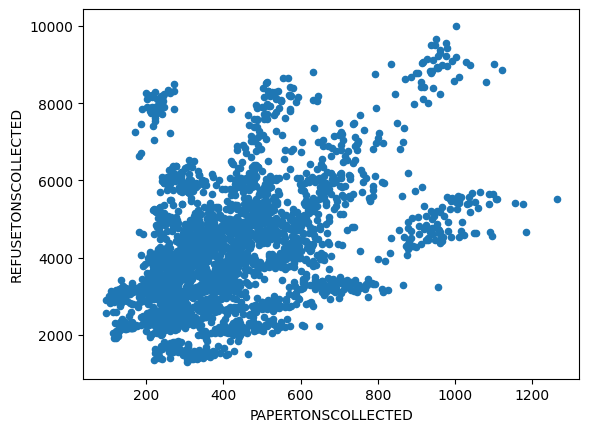

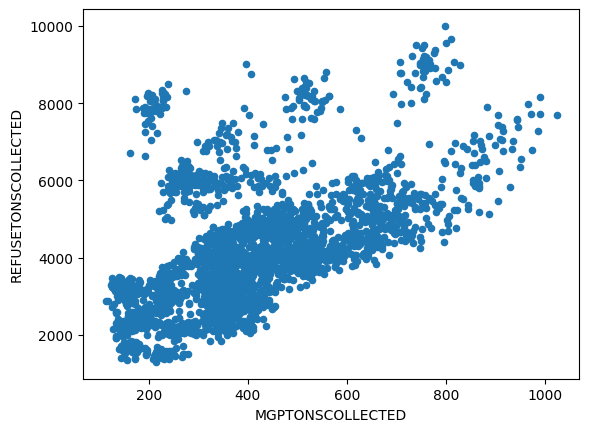

In [674]:
newdata = df[(df['MONTH'] >= '2022-01-01')]

# plots of both papers and mgptons are linear
display(newdata.plot(kind='scatter',x='PAPERTONSCOLLECTED',y='REFUSETONSCOLLECTED'))
display(newdata.plot(kind='scatter',x='MGPTONSCOLLECTED',y='REFUSETONSCOLLECTED'))

In [675]:
recycles = newdata['PAPERTONSCOLLECTED'] + newdata['MGPTONSCOLLECTED']
total = newdata['PAPERTONSCOLLECTED'] + newdata['MGPTONSCOLLECTED'] + newdata['REFUSETONSCOLLECTED']

newdata['proportionrefuse'] = recycles / total

newdata['proportionrefuse'].describe()

newdata['id'] = newdata['BOROUGH'] + newdata['COMMUNITYDISTRICT'].astype(str)

modeldata = newdata[['MONTH','id','proportionrefuse','REFUSETONSCOLLECTED','PAPERTONSCOLLECTED','MGPTONSCOLLECTED']]

modeldata['id'] = modeldata['id'].str.lower().str.strip()

modeldata.info()
#meanproportions = newdata.groupby(['BOROUGH','COMMUNITYDISTRICT']).agg({'proportionrefuse':['mean']}).reset_index()
#meanproportions[['BOROUGH','COMMUNITYDISTRICT','proportionrefuse']].sort_values(by=('proportionrefuse','mean'),ascending=False)

<class 'pandas.core.frame.DataFrame'>
Index: 2714 entries, 0 to 2713
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   MONTH                2714 non-null   datetime64[ns]
 1   id                   2714 non-null   object        
 2   proportionrefuse     2714 non-null   float64       
 3   REFUSETONSCOLLECTED  2714 non-null   float64       
 4   PAPERTONSCOLLECTED   2714 non-null   float64       
 5   MGPTONSCOLLECTED     2714 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 148.4+ KB


/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_57940/2503280654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata['proportionrefuse'] = recycles / total
/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_57940/2503280654.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata['id'] = newdata['BOROUGH'] + newdata['COMMUNITYDISTRICT'].astype(str)
/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_57940/2503280654.py:12: SettingWithCopyWarning: 
A value is trying to be

In [676]:
# user input to filter our timeseries for a

attempts = 0
max_attempts = 100000
listofunique = []

for i in range(len(modeldata['id'].unique())):
    listofunique.append(modeldata['id'].iloc[i])

#list of each unique identifier in data
listofunique

while attempts < max_attempts:
    user_input = input("Enter a borough and district (FORMAT: bronx1): ")
    user_input = user_input.lower().strip()
    if user_input in listofunique:
        break
    else:
        raise ValueError("Not a valid district")
        attempts += 1

if attempts == max_attempts:
    raise ValueError("Too many invalid attempts")

In [677]:
# filter df and creating data for timeseries (s)

filtered = modeldata[modeldata['id'] == user_input]
filtered = filtered[(filtered['MONTH'] >= '2023') & (filtered['MONTH'] < '2025')]

s = filtered.set_index(filtered['MONTH'])['proportionrefuse'].asfreq('D')
s = s.dropna()


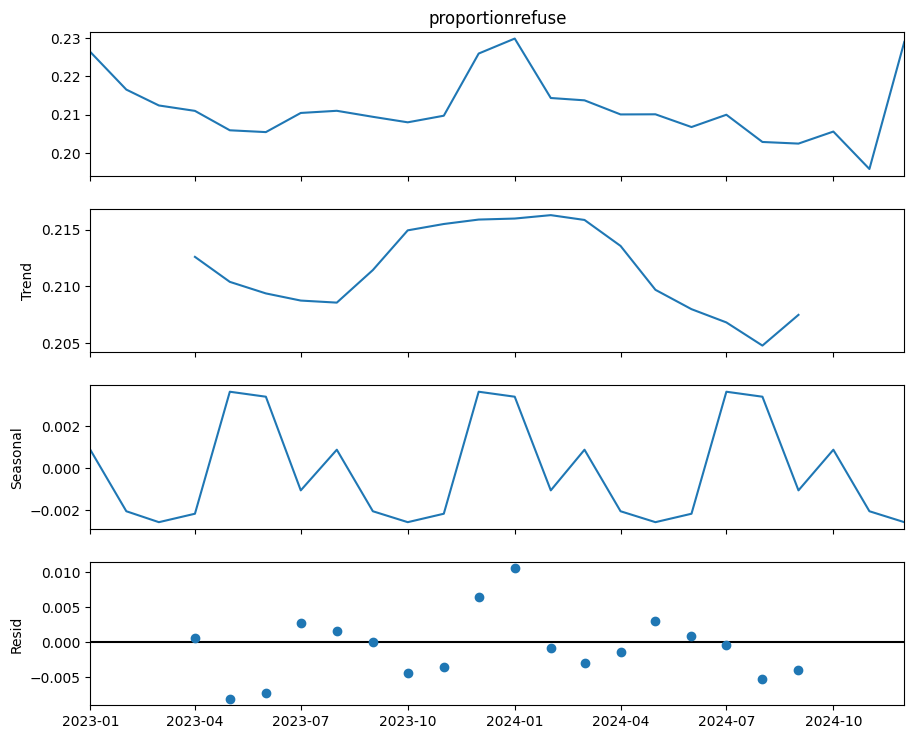

In [678]:
# Decompose the time series (assuming a 12-month cycle)
decomp = seasonal_decompose(s, model='additive', period=7)

# Plot the decomposition
fig = decomp.plot()
fig.set_size_inches(10, 8)
plt.show()

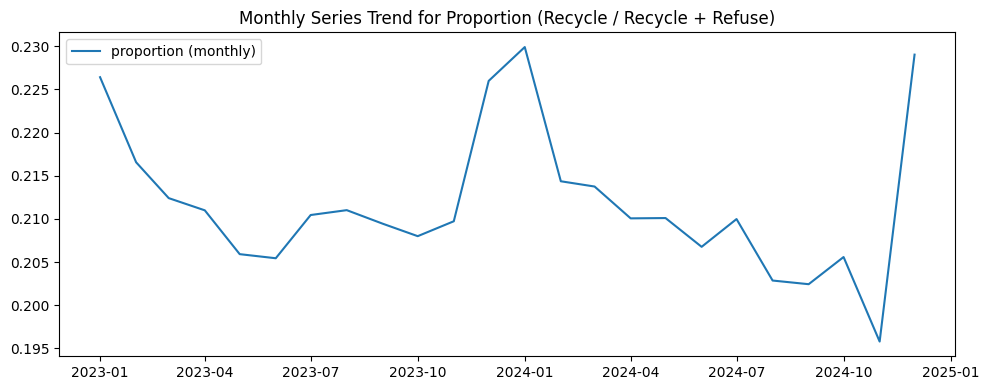

In [679]:
# Quick peek
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(s, label="proportion (monthly)")
ax.set_title("Monthly Series Trend for Proportion (Recycle / Recycle + Refuse)")
ax.legend()
plt.tight_layout()
plt.show()


In [680]:
# train test splits
split_idx = int(len(s) * 0.70)
# all of 2023
train = s.iloc[:split_idx]
# all of 2024
test  = s.iloc[split_idx:]


In [681]:
baseline_pred = pd.Series(train.iloc[-1], index=test.index)
rmse_baseline = np.sqrt(mean_squared_error(test,baseline_pred))
rmse_baseline

np.float64(0.009391095019830441)

Train: 2023-01-01 → 2024-04-01 | n = 16
Test : 2024-05-01 → 2024-12-01 | n = 8


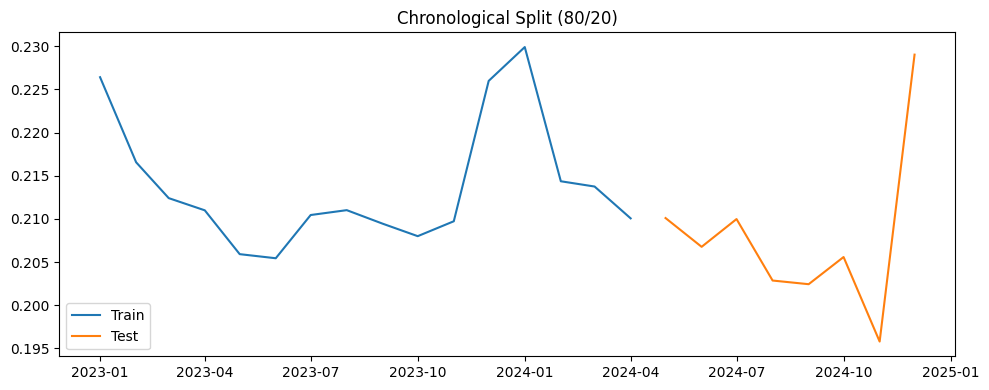

In [682]:
print("Train:", train.index.min().date(), "→", train.index.max().date(), "| n =", len(train))
print("Test :", test.index.min().date(),  "→", test.index.max().date(),  "| n =", len(test))

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test,  label="Test", color="#ff7f0e")
plt.title("Chronological Split (80/20)")
plt.legend()
plt.tight_layout()
plt.show()

# getting into some modeling

In [683]:
# --- Fit SARIMA(p, d, q)(P, D, Q)s ---
model = SARIMAX(
    train,
    order=(1, 1, 1),        # ARIMA part: p, d, q
    seasonal_order=(1, 1, 1, 12),   # Seasonal: P, D, Q, s (e.g., 12 months)
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                   proportionrefuse   No. Observations:                   16
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Wed, 10 Dec 2025   AIC                             10.000
Time:                                    13:25:11   BIC                                nan
Sample:                                01-01-2023   HQIC                               nan
                                     - 04-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0   

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parame

Sarima (1,1,1,12) RMSE: 0.006


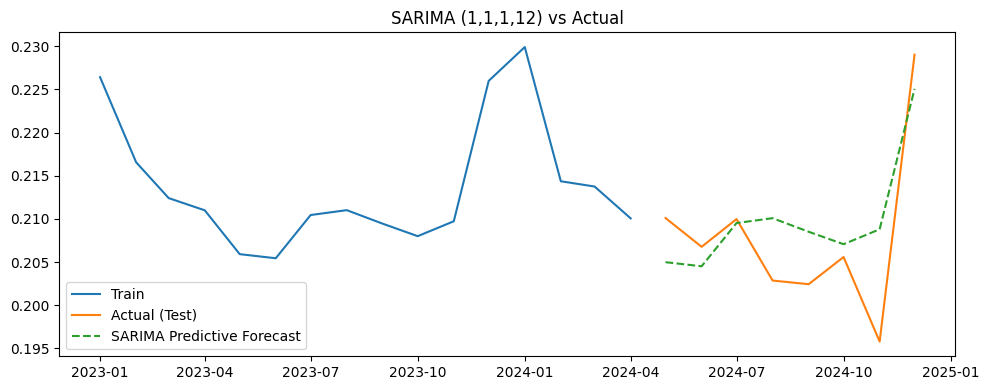

2024-05-01    0.204979
2024-06-01    0.204504
2024-07-01    0.209517
2024-08-01    0.210081
2024-09-01    0.208505
2024-10-01    0.207065
2024-11-01    0.208793
2024-12-01    0.225067
Freq: MS, Name: predicted_mean, dtype: float64

In [690]:
predictions = results.forecast(steps=len(test))
sarima_rmse = np.sqrt(mean_squared_error(test, predictions))

print(f"Sarima (1,1,1,12) RMSE: {sarima_rmse:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(predictions, label="SARIMA Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("SARIMA (1,1,1,12) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

predictions

In [685]:
# Fit ARIMA on TRAIN only
# simple model to find fine tuned model
model = ARIMA(train, order=(1,1,1))
fit = model.fit()

# Residuals from the fitted model (in-sample)
resid = fit.resid


/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


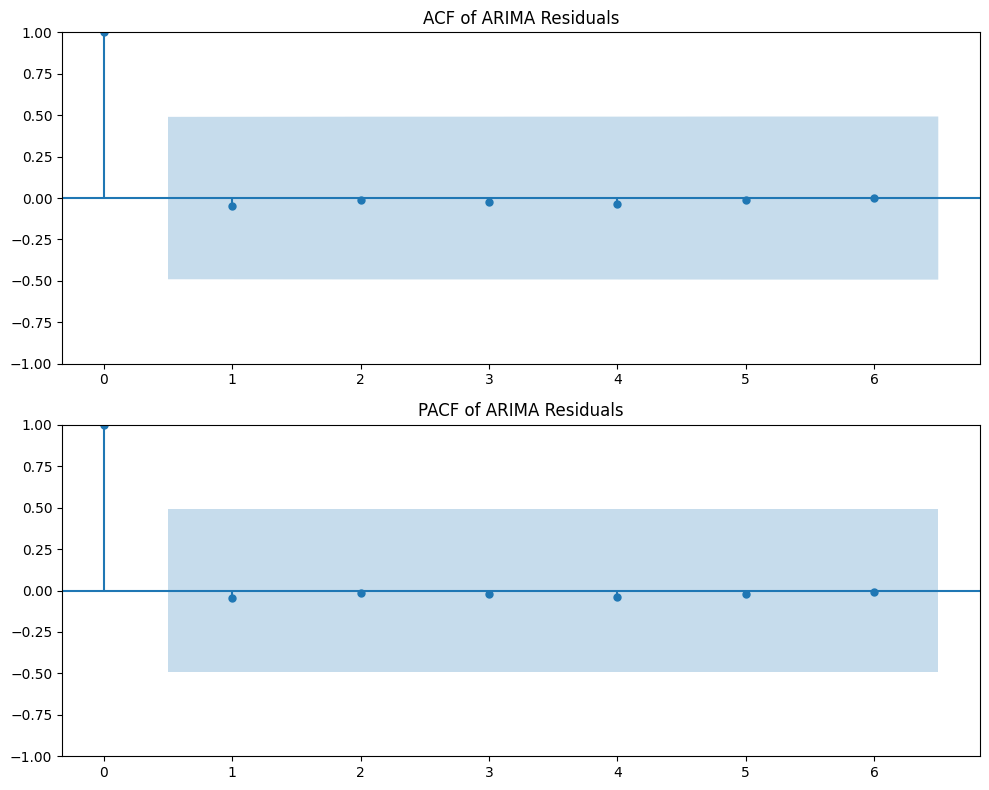

In [686]:
# CELL 3 — Residual ACF & PACF

fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(resid, ax=ax[0], lags=6)
ax[0].set_title("ACF of ARIMA Residuals")

plot_pacf(resid, ax=ax[1], lags=6, method="ywm")
ax[1].set_title("PACF of ARIMA Residuals")

plt.tight_layout()
plt.show()

Arima (1,1,1) RMSE: 0.010


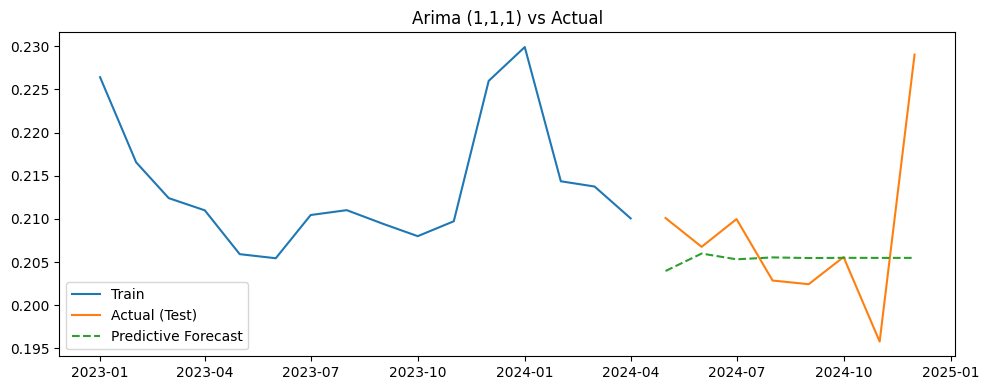

2024-05-01    0.203959
2024-06-01    0.205981
2024-07-01    0.205311
2024-08-01    0.205533
2024-09-01    0.205460
2024-10-01    0.205484
2024-11-01    0.205476
2024-12-01    0.205479
Freq: MS, Name: predicted_mean, dtype: float64

In [687]:
predictions = fit.forecast(steps=len(test))
arima_rmse = np.sqrt(mean_squared_error(test, predictions))

print(f"Arima (1,1,1) RMSE: {arima_rmse:,.3f}")

plt.figure(figsize=(10,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual (Test)", color="#ff7f0e")
plt.plot(predictions, label="Predictive Forecast", color="#2ca02c", linestyle="--")
plt.title("Arima (1,1,1) vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

predictions

In [688]:
newdata["YEAR"]= newdata["MONTH"].dt.year
newdata.groupby(['YEAR','COMMUNITYDISTRICT']).agg({"REFUSETONSCOLLECTED":"sum"})

/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_57940/31618268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata["YEAR"]= newdata["MONTH"].dt.year


REFUSETONSCOLLECTED
YEAR COMMUNITYDISTRICT                     
2022 1                             247227.8
     2                             263537.3
     3                             281143.7
     4                             191301.1
     5                             176799.9
...                                     ...
2025 14                             82483.6
     15                             44210.4
     16                             29074.6
     17                             44155.7
     18                             51970.3

[72 rows x 1 columns]

In [689]:
bronxdf = newdata[newdata["BOROUGH"] == "Bronx"]
manhattandf = newdata[newdata["BOROUGH"] == "Manhattan"]
brooklyndf = newdata[newdata["BOROUGH"] == "Brooklyn"]
queensdf = newdata[newdata["BOROUGH"] == "Queens"]
statenisland = newdata[newdata["BOROUGH"] == "Staten Island"]
#brooklyndf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line')
bronxdf['COMMUNITYDISTRICT'].

#display(bronxdf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'),
#        manhattandf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'),
#        brooklyndf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'),
#        queensdf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'),
#        statenisland.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'))


SyntaxError: invalid syntax (2024640063.py, line 7)

/var/folders/3y/ldxff8k17wjcyzkq19xw1srm0000gn/T/ipykernel_51833/1465298311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata['paperxmgp'] = (newdata['PAPERTONSCOLLECTED'] * newdata['MGPTONSCOLLECTED'])


<Axes: xlabel='paperxmgp', ylabel='REFUSETONSCOLLECTED'>

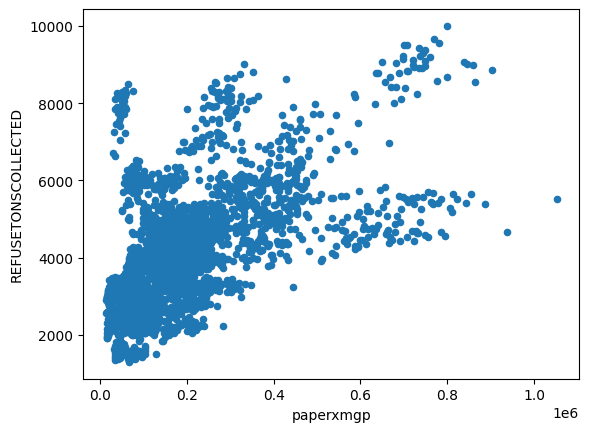

In [ ]:
newdata['paperxmgp'] = (newdata['PAPERTONSCOLLECTED'] * newdata['MGPTONSCOLLECTED'])

# how else can we proportionately compare

newdata.plot(kind='scatter',x='paperxmgp',y='REFUSETONSCOLLECTED')

<Axes: xlabel='COMMUNITYDISTRICT,YEAR'>

<Axes: xlabel='COMMUNITYDISTRICT,YEAR'>

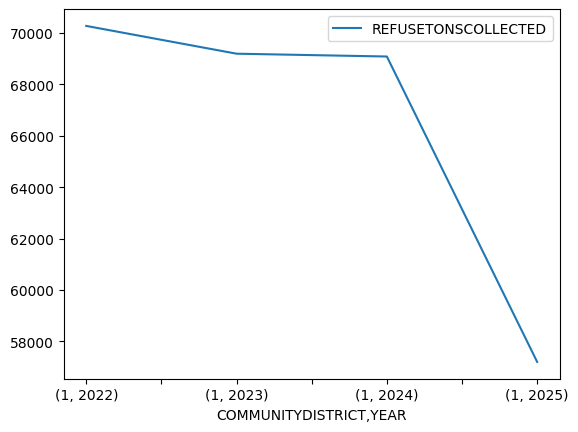

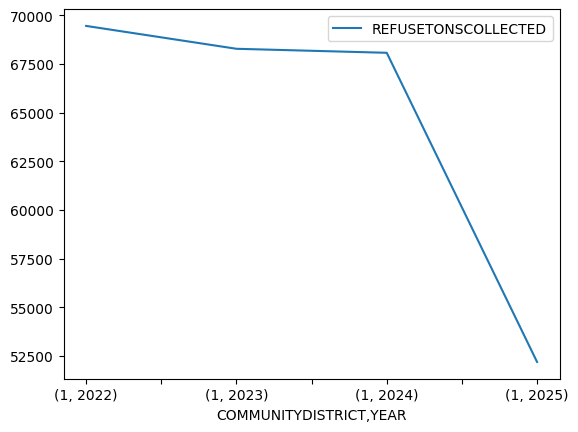

In [ ]:
bronxdisonedf = newdata[(newdata["BOROUGH"] == "Brooklyn") & (newdata['COMMUNITYDISTRICT'] == 1)]
bronxdistwodf = newdata[(newdata["BOROUGH"] == "Staten Island") & (newdata['COMMUNITYDISTRICT'] == 1)]

display(bronxdisonedf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'))
display(bronxdistwodf.groupby(['COMMUNITYDISTRICT','YEAR']).agg({"REFUSETONSCOLLECTED":"sum"}).plot(kind = 'line'))

In [ ]:
# building a pipeline

# checking if bmi and sex contribute to disease progression
num_features = ['PAPERTONSCOLLECTED','MGPTONSCOLLECTED','paperxmgp']
# also checking if age contributes

num_pipe = Pipeline([
    ("scale", StandardScaler())
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_features),
])

model = Pipeline([
    ("prep", preprocess),
    ("reg", LinearRegression())
])
